In [13]:
import boto3
import os
from tqdm import tqdm
from dotenv import load_dotenv

load_dotenv()
access_key_id = os.getenv("ACCESS_KEY_ID")
secret_access_key = os.getenv("SECRET_ACCESS_KEY")
minio_url = "http://" + os.getenv("S3_API_ENDPOINT")


minio_client = boto3.client(
    "s3",
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    endpoint_url=minio_url
)

new_bucket = "trusted-zone"
try:
    minio_client.create_bucket(Bucket=new_bucket)
except (minio_client.exceptions.BucketAlreadyExists, minio_client.exceptions.BucketAlreadyOwnedByYou):
    print(f"Bucket '{new_bucket}' already exists")

Bucket 'trusted-zone' already exists


`analisi_text()` function performs comprehensive quality analysis on text. It detects: control characters, lines with spaces, multiple line breaks, empty lines, special characters, typographic quotes/apostrophes, multiple hyphens, and empty text.


In [8]:
import unicodedata
import re

def analisi_text(text):
    problemas = {}

    control_chars = [c for c in text if unicodedata.category(c)[0] == 'C' and c not in '\n\t']
    problemas["caracteres_control"] = len(control_chars)

    lineas_con_espacios = [line for line in text.splitlines() if line.startswith(" ") or line.endswith(" ")]
    problemas["lineas_con_espacios"] = len(lineas_con_espacios)

    saltos_multiples = bool(re.search(r"\n\s*\n\s*\n+", text))
    problemas["saltos_multiples"] = saltos_multiples

    lineas_vacias = [line for line in text.splitlines() if not line.strip()]
    problemas["lineas_vacias"] = len(lineas_vacias)

    caracteres_invalidos = re.findall(r"[^\w\s\.\,\;\:\!\?\(\)\[\]\"\'\-\+\=\%\&\$\/\@\#\*]", text)
    problemas["caracteres_especiales"] = len(caracteres_invalidos)

    comillas_tipograficas = re.findall(r"[“”«»]", text)
    apostrofes_tipograficos = re.findall(r"[‘’]", text)
    problemas["comillas_tipograficas"] = len(comillas_tipograficas)
    problemas["apostrofes_tipograficos"] = len(apostrofes_tipograficos)

    guiones_multiples = bool(re.search(r"-{2,}", text))
    problemas["guiones_multiples"] = guiones_multiples

    texto_vacio = not text.strip()
    problemas["texto_vacio"] = texto_vacio

    return{
        "problems_control_caracters": problemas["caracteres_control"],
        "problems_lineas_con_espacios": problemas["lineas_con_espacios"],
        "problems_saltos_multiples": problemas["saltos_multiples"],
        "problems_lineas_vacias": problemas["lineas_vacias"],
        "problems_caracteres_especiales": problemas["caracteres_especiales"],
        "problems_comillas_tipograficas": problemas["comillas_tipograficas"],
        "problems_apostrofes_tipograficos": problemas["apostrofes_tipograficos"],
        "problems_guiones_multiples": problemas["guiones_multiples"],
        "problems_texto_vacio": problemas["texto_vacio"]
    }

Iterates through all text files in the "formatted-zone" bucket, reads each text file, runs the quality analysis function on it, and stores the results in a pandas DataFrame for further analysis and visualization.


In [9]:
import pandas as pd
from tqdm import tqdm
analysis = []

paginator = minio_client.get_paginator("list_objects_v2")

for page in paginator.paginate(Bucket="formatted-zone", Prefix="text/"):
    for obj in tqdm(page.get("Contents", []), desc="Processant fitxers de text"):
        key = obj["Key"]
        filename = key.split("/")[-1]
        response = minio_client.get_object(Bucket="formatted-zone", Key=key)
        text = response["Body"].read().decode("utf-8", errors="ignore")
        analysis.append(analisi_text(text))
        

df = pd.DataFrame(analysis)
df.head()

Processant fitxers de text: 100%|██████████| 5/5 [00:00<00:00, 181.24it/s]


,problems_control_caracters,problems_lineas_con_espacios,problems_saltos_multiples,problems_lineas_vacias,problems_caracteres_especiales,problems_comillas_tipograficas,problems_apostrofes_tipograficos,problems_guiones_multiples,problems_texto_vacio
0,0,0,False,53,15,0,0,False,False
1,0,0,False,42,7,0,0,False,False
2,0,1,False,132,16,0,0,False,False
3,0,0,False,53,3,0,0,False,False
4,0,0,True,21,0,0,0,False,False


In [10]:
# STATISTICAL SUMMARY
print("="*80)
print("Text Quality Analysis - Summary Statistics")
print("="*80 + "\n")

print(f"Total files analyzed: {len(df)}\n")

print("CONTROL CHARACTERS:")
print(f"   Files with control characters: {df[df['problems_control_caracters'] > 0].shape[0]} ({(df[df['problems_control_caracters'] > 0].shape[0]/len(df)*100):.1f}%)\n")

print("TRAILING/LEADING SPACES:")
print(f"   Average lines with spaces per file: {df['problems_lineas_con_espacios'].mean():.1f}")
print(f"   Max lines with spaces in a single file: {df['problems_lineas_con_espacios'].max()}\n")

print("LINE BREAKS:")
print(f"   Files with multiple line breaks: {df['problems_saltos_multiples'].sum()} ({(df['problems_saltos_multiples'].sum()/len(df)*100):.1f}%)\n")

print("EMPTY LINES:")
print(f"   Average empty lines per file: {df['problems_lineas_vacias'].mean():.1f}")
print(f"   Max empty lines in a single file: {df['problems_lineas_vacias'].max()}\n")

print("SPECIAL CHARACTERS:")
print(f"   Average special characters per file: {df['problems_caracteres_especiales'].mean():.1f}")
print(f"   Files with >20 special characters: {(df['problems_caracteres_especiales'] > 20).sum()}\n")

print("TYPOGRAPHIC CHARACTERS:")
print(f"   Files with typographic quotes: {(df['problems_comillas_tipograficas'] > 0).sum()}")
print(f"   Files with typographic apostrophes: {(df['problems_apostrofes_tipograficos'] > 0).sum()}\n")

print("MULTIPLE HYPHENS:")
print(f"   Files with multiple hyphens: {df['problems_guiones_multiples'].sum()} ({(df['problems_guiones_multiples'].sum()/len(df)*100):.1f}%)\n")

print("EMPTY FILES:")
print(f"   Empty text files: {df['problems_texto_vacio'].sum()} ({(df['problems_texto_vacio'].sum()/len(df)*100):.1f}%)\n")

print("="*80)


Text Quality Analysis - Summary Statistics

Total files analyzed: 5

CONTROL CHARACTERS:
   Files with control characters: 0 (0.0%)

TRAILING/LEADING SPACES:
   Average lines with spaces per file: 0.2
   Max lines with spaces in a single file: 1

LINE BREAKS:
   Files with multiple line breaks: 1 (20.0%)

EMPTY LINES:
   Average empty lines per file: 60.2
   Max empty lines in a single file: 132

SPECIAL CHARACTERS:
   Average special characters per file: 8.2
   Files with >20 special characters: 0

TYPOGRAPHIC CHARACTERS:
   Files with typographic quotes: 0
   Files with typographic apostrophes: 0

MULTIPLE HYPHENS:
   Files with multiple hyphens: 0 (0.0%)

EMPTY FILES:
   Empty text files: 0 (0.0%)



Generates and prints a comprehensive statistical summary of all text quality metrics. It calculates percentages, averages, and maximum values for each type of problem detected across all files, providing a quick overview of the dataset's overall quality health.


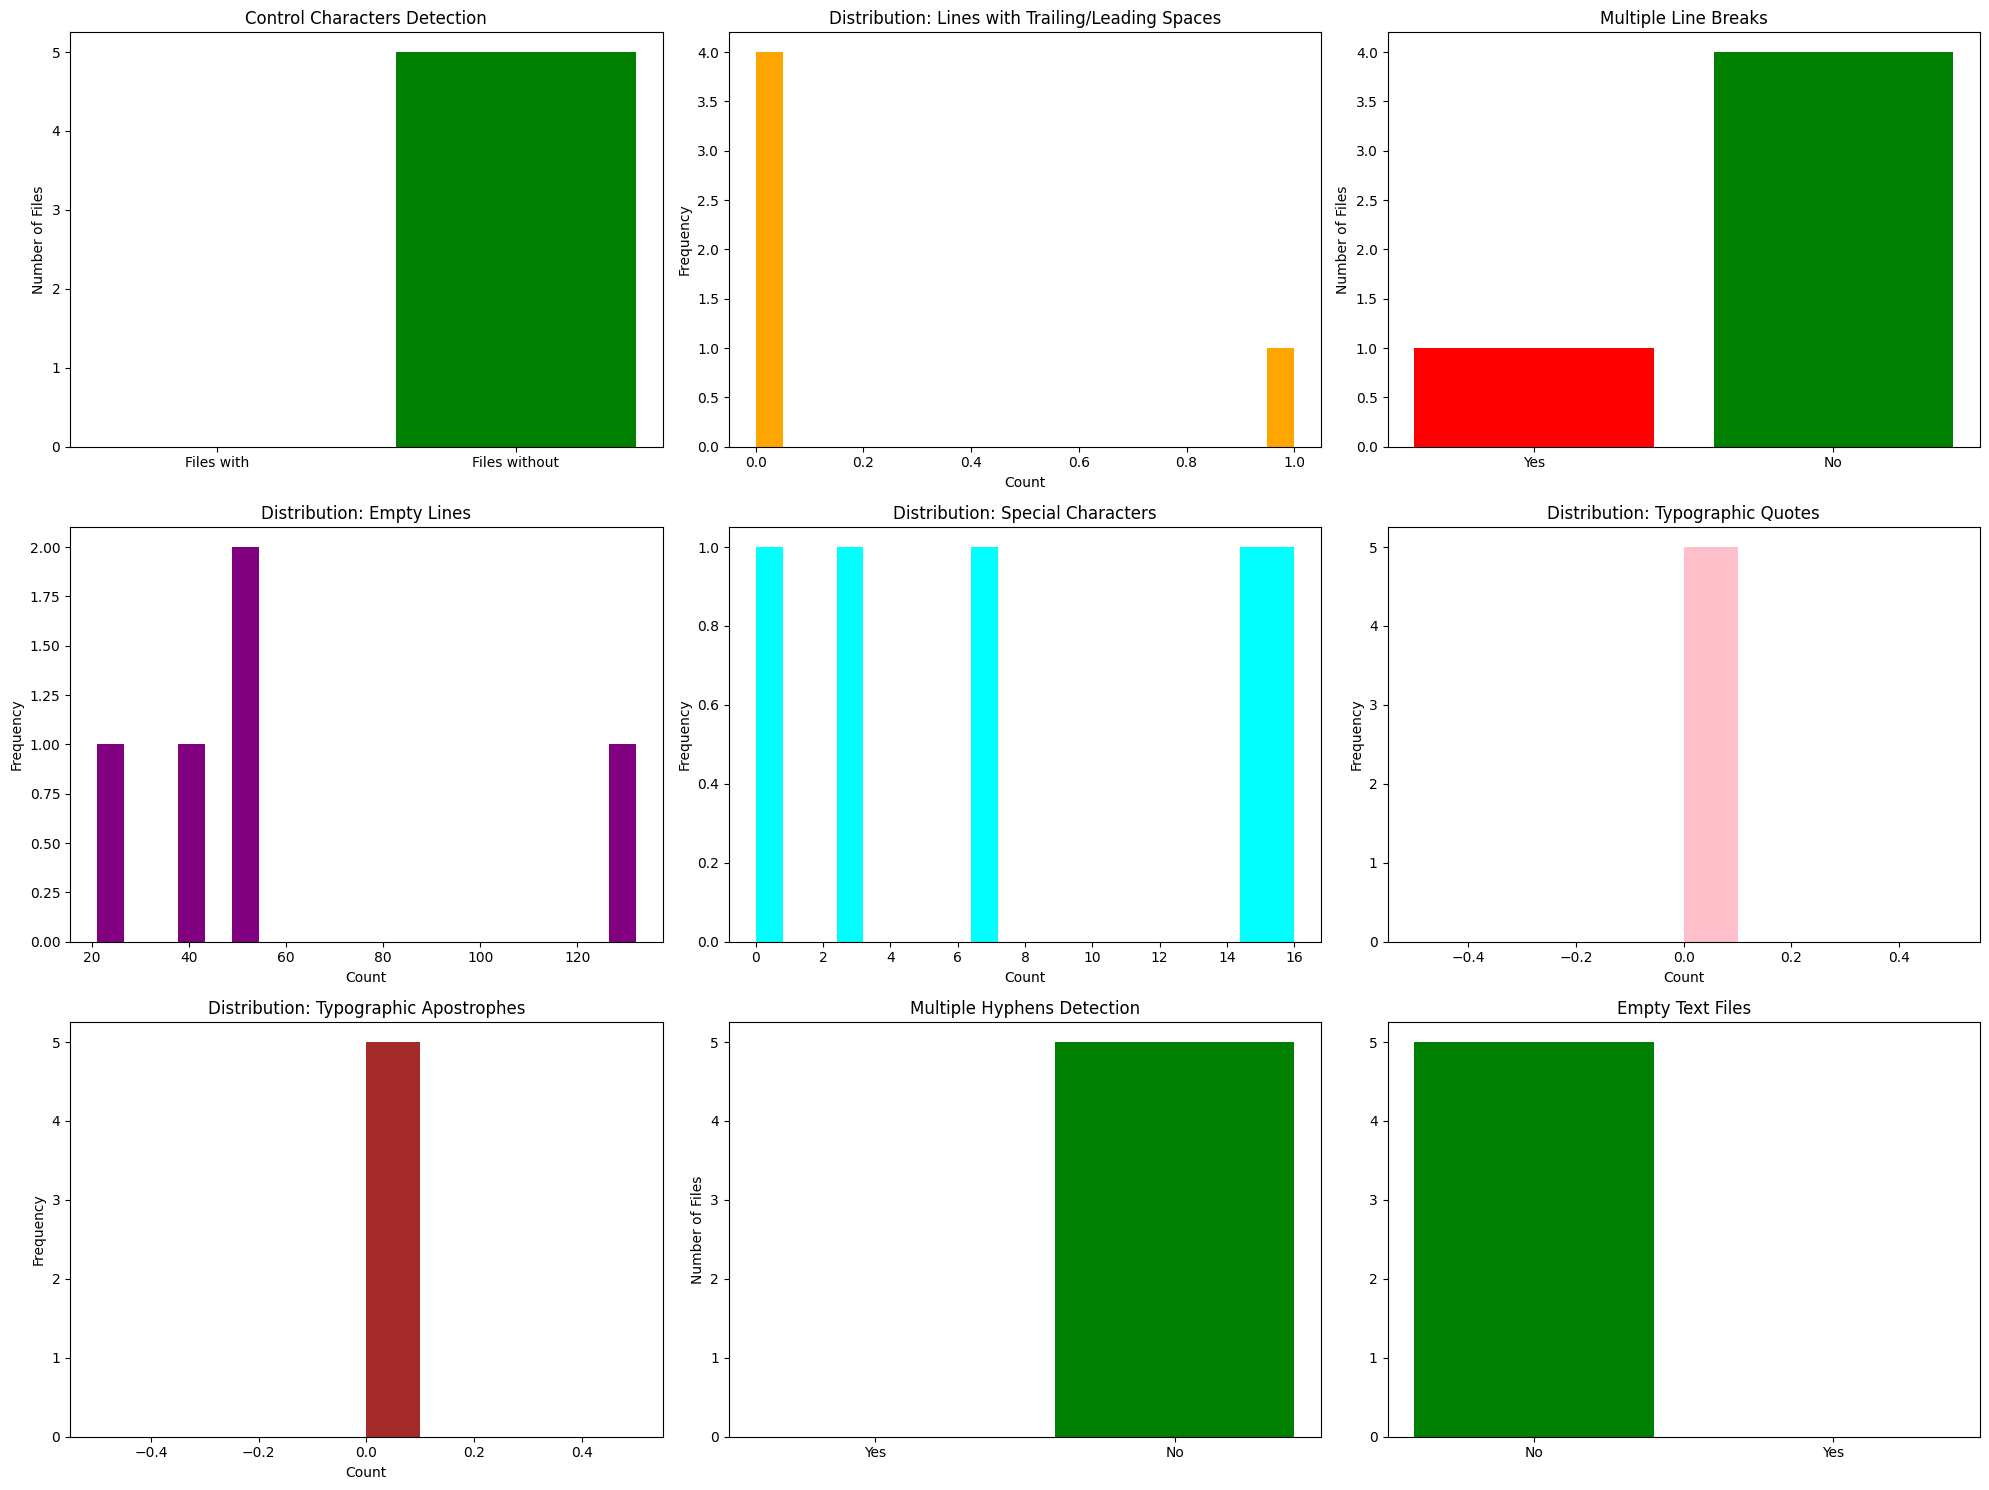

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# OVERALL QUALITY SUMMARY
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# 1. Control characters
axes[0, 0].bar(['Files with', 'Files without'], 
               [df[df['problems_control_caracters'] > 0].shape[0],
                df[df['problems_control_caracters'] == 0].shape[0]],
               color=['red', 'green'])
axes[0, 0].set_title('Control Characters Detection')
axes[0, 0].set_ylabel('Number of Files')

# 2. Lines with spaces
axes[0, 1].hist(df['problems_lineas_con_espacios'], bins=20, color='orange')
axes[0, 1].set_title('Distribution: Lines with Trailing/Leading Spaces')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_ylabel('Frequency')

# 3. Multiple line breaks
axes[0, 2].bar(['Yes', 'No'], 
               [df['problems_saltos_multiples'].sum(),
                len(df) - df['problems_saltos_multiples'].sum()],
               color=['red', 'green'])
axes[0, 2].set_title('Multiple Line Breaks')
axes[0, 2].set_ylabel('Number of Files')

# 4. Empty lines
axes[1, 0].hist(df['problems_lineas_vacias'], bins=20, color='purple')
axes[1, 0].set_title('Distribution: Empty Lines')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Frequency')

# 5. Special characters
axes[1, 1].hist(df['problems_caracteres_especiales'], bins=20, color='cyan')
axes[1, 1].set_title('Distribution: Special Characters')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Frequency')

# 6. Typographic quotes
axes[1, 2].hist(df['problems_comillas_tipograficas'], bins=10, color='pink')
axes[1, 2].set_title('Distribution: Typographic Quotes')
axes[1, 2].set_xlabel('Count')
axes[1, 2].set_ylabel('Frequency')

# 7. Typographic apostrophes
axes[2, 0].hist(df['problems_apostrofes_tipograficos'], bins=10, color='brown')
axes[2, 0].set_title('Distribution: Typographic Apostrophes')
axes[2, 0].set_xlabel('Count')
axes[2, 0].set_ylabel('Frequency')

# 8. Multiple hyphens
axes[2, 1].bar(['Yes', 'No'], [df['problems_guiones_multiples'].sum(),
                len(df) - df['problems_guiones_multiples'].sum()],color=['red', 'green'])
axes[2, 1].set_title('Multiple Hyphens Detection')
axes[2, 1].set_ylabel('Number of Files')

# 9. Empty text
axes[2, 2].bar(['No', 'Yes'], 
    [len(df) - df['problems_texto_vacio'].sum(),
                df['problems_texto_vacio'].sum()],
               color=['green', 'red'])
axes[2, 2].set_title('Empty Text Files')
plt.tight_layout()
plt.show()


## Text Quality Analysis

### **Interpretation of the Text Visualizations**

Each chart in this grid provides insights into different text quality aspects:

1. **Control Characters**: Green means clean files, red indicates potential encoding issues. These invisible characters can cause problems in text processing.

2. **Lines with Spaces**: Distribution shows formatting consistency; peaks near 0 are ideal. Leading/trailing spaces on lines indicate formatting problems.

3. **Multiple Line Breaks**: Yes/No comparison reveals excessive whitespace issues. Multiple consecutive line breaks create inconsistent spacing.

4. **Empty Lines**: Normal distribution indicates proper paragraph structure. Too many empty lines (>100 per file) may indicate formatting issues.

5. **Special Characters**: Low counts (<20) are acceptable for most text processing tasks. High counts may indicate encoding issues or unusual characters.

6. **Typographic Quotes**: Should ideally be 0; these need ASCII replacement. Fancy quotes ("") can cause processing issues.

7. **Typographic Apostrophes**: Same as quotes - ideally 0 for clean text. Fancy apostrophes ('') need to be replaced with standard ones.

8. **Multiple Hyphens**: Yes indicates potential formatting artifacts. Multiple hyphens (--) may need to be replaced with em-dashes.

9. **Empty Text**: Critical issue if any files have this problem. Completely empty files indicate data quality problems.

**Key Takeaways**:
- Most files should show green bars (no problems) for categorical issues
- Histograms should show low counts concentrated near 0
- Files with high counts or red bars need attention
- All files should ideally have 0 typographic characters
- Empty text files must be removed from the dataset

**What the Patterns Tell You**:
- Concentrated distributions around 0 = healthy, clean dataset
- Wide spread or high values = potential quality issues requiring preprocessing
- Red bars in categorical charts = files needing immediate attention


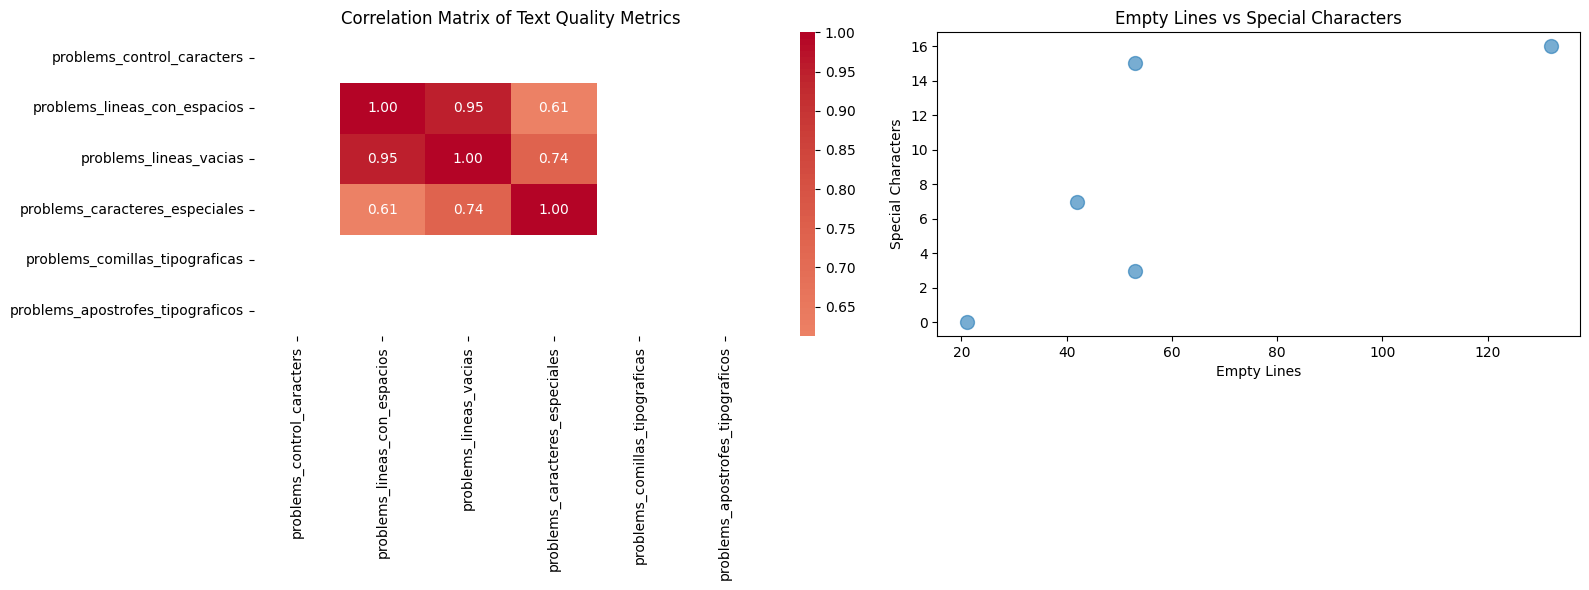

In [15]:
# CORRELATION ANALYSIS
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlation matrix
correlation_metrics = ['problems_control_caracters', 'problems_lineas_con_espacios','problems_lineas_vacias', 'problems_caracteres_especiales','problems_comillas_tipograficas', 'problems_apostrofes_tipograficos']
corr_matrix = df[correlation_metrics].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Correlation Matrix of Text Quality Metrics')

# Empty lines vs Special characters
axes[1].scatter(df['problems_lineas_vacias'], df['problems_caracteres_especiales'], alpha=0.6, s=100)
axes[1].set_title('Empty Lines vs Special Characters')
axes[1].set_xlabel('Empty Lines')
axes[1].set_ylabel('Special Characters')

plt.tight_layout()
plt.show()


### **What This Correlation Analysis Shows**

**Correlation Matrix**: This heatmap identifies relationships between different text quality metrics:
- **Positive correlations (red)**: Two metrics increase or decrease together. For example, if empty lines and special characters are positively correlated, files with more empty lines tend to have more special characters.
- **Negative correlations (blue)**: One metric increases while the other decreases. For instance, if control characters and typographic quotes are negatively correlated, files with more control characters tend to have fewer typographic quotes.
- **Near-zero correlations**: Metrics are independent. This helps identify which quality aspects are unrelated.

**Empty Lines vs Special Characters Scatter Plot**: This visualization reveals patterns between formatting issues and character problems:
- **Cloud pattern**: Shows natural variation in the dataset
- **Positive trend**: Increasing empty lines associated with increasing special characters may indicate files with multiple formatting and encoding issues
- **Negative trend or clustering**: May indicate different types of quality problems in different files
- **Outliers**: Points far from the main cloud may represent problematic files that need attention
